# bgfs.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `data/us_counties_clean.csv`: The contents of `data/us_counties.csv` after data cleaning by `clean.ipynb`
* `data/us_counties_clean_meta.json`: Column type metadata for reading `data/us_counties_clean.csv` with `pd.read_csv()`

Outputs:
* `data/us_counties_curves.csv`: The curves that this notebook generated
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`


In [1]:
# Initialization boilerplate
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64



In [2]:
# Read in the CSV file and apply the saved type information
csv_file = "data/us_counties_clean.csv"
meta_file = "data/us_counties_clean_meta.json"

# Read column type metadata
with open(meta_file) as f:
    cases_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
cases_meta["Date"] = "object"

cases_vertical = (
    pd
    .read_csv(csv_file, dtype=cases_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-18  Wyoming   Weston        6927          0       0          0   
      2020-04-19  Wyoming   Weston        6927          0       0          0   
      2020-04-20  Wyoming   Weston        6927          0       0          0   
      2020-04-21  Wyoming   Weston        6927          0       0          0   
      2020-04-22  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22              False           False              False  
      2020-01-23              False           False              False  
      2020-01-24              False           False              False  
      2020-01-25              False           False              False  
      2020-01-26              False           False              False  
...                             ...             ...                ...  
56045 2020-04-18              False           False              False  
      2020-04-19              False           False              False  
      2020-04-20              False           False              False  
      2020-04-21              False           False              False  
      2020-04-22              False           False              False  

[289064 rows x 9 columns]

In [3]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
for col in ["Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"]:
    cases_vertical[col] = cases_vertical[col].astype(np.int8)
cases_vertical

State   County  Population  Confirmed  Deaths  Recovered  \
FIPS  Date                                                                     
1001  2020-01-22  Alabama  Autauga       55869          0       0          0   
      2020-01-23  Alabama  Autauga       55869          0       0          0   
      2020-01-24  Alabama  Autauga       55869          0       0          0   
      2020-01-25  Alabama  Autauga       55869          0       0          0   
      2020-01-26  Alabama  Autauga       55869          0       0          0   
...                   ...      ...         ...        ...     ...        ...   
56045 2020-04-18  Wyoming   Weston        6927          0       0          0   
      2020-04-19  Wyoming   Weston        6927          0       0          0   
      2020-04-20  Wyoming   Weston        6927          0       0          0   
      2020-04-21  Wyoming   Weston        6927          0       0          0   
      2020-04-22  Wyoming   Weston        6927          0       0          0   

                  Confirmed_Outlier  Deaths_Outlier  Recovered_Outlier  
FIPS  Date                                                              
1001  2020-01-22                  0               0                  0  
      2020-01-23                  0               0                  0  
      2020-01-24                  0               0                  0  
      2020-01-25                  0               0                  0  
      2020-01-26                  0               0                  0  
...                             ...             ...                ...  
56045 2020-04-18                  0               0                  0  
      2020-04-19                  0               0                  0  
      2020-04-20                  0               0                  0  
      2020-04-21                  0               0                  0  
      2020-04-22                  0               0                  0  

[289064 rows x 9 columns]

In [4]:
# Collapse each time series or mask down to a single cell
cases, dates = util.collapse_time_series(cases_vertical, [
    "Confirmed", "Deaths", "Recovered", 
    "Confirmed_Outlier", "Deaths_Outlier", "Recovered_Outlier"])
cases

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier
FIPS,,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1007,Alabama,Bibb,22394,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1009,Alabama,Blount,57826,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56039,Wyoming,Teton,23464,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
56041,Wyoming,Uinta,20226,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [5]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

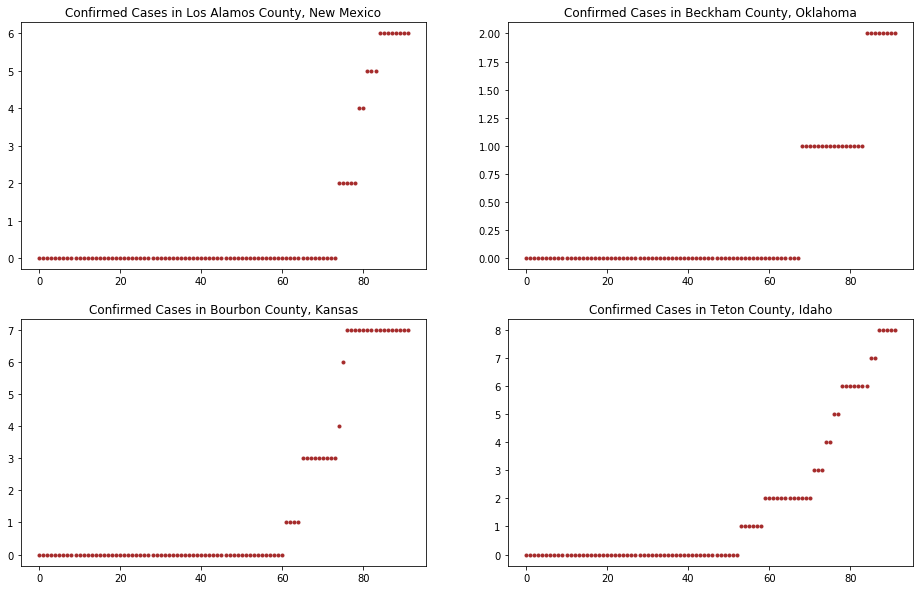

In [6]:
# Because these time series are integer-valued, there can be
# problems with aliasing. 
# Here are some examples of what aliasing looks like:
# (graph_examples() function defined in util.py)
util.graph_examples(cases, ts_col_name, {}, 
                    mask=(np.max(cases[ts_col_name].values, axis=1) < 10))

In [7]:
# To avoid problems due to aliasing, we will restrict the analysis
# in the rest of this notebook to time series whose maximum values
# go above a threshold:
alias_threshold = 100

# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].values, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].values, axis=1) >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].values[:,first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].values[:,first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorType):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)
        
filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier
FIPS,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,[ 0 0 0 0 0 0 1 4 4 4 4 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55079,Wisconsin,Milwaukee,945726,[ 0 0 0 2 6 6 13 24 47 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [8]:
# Warm-up: Fit a straight line.
# We use sklearn's implementation of BGFS as the optimizer.

# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].values.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)

def linear_curve(m, b):
    return m * x + b

def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)

linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))

linear = filtered[metadata_cols].copy()
linear["Result_Object"] = [
    scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(ts), bounds=linear_bounds)
    for ts in series_values
]
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 10761.953981679906, 'jac': [0.00018189...",3.045736,-28.051500,[-28.05149984 -25.00576393 -21.96002803 -18.914...,0.859466
1017,Alabama,Chambers,33254,"{'fun': 53508.894619814826, 'jac': [-0.0007275...",6.433149,-44.000000,[-44. -37.56685135 -31.13370271 -24.700...,0.869669
1055,Alabama,Etowah,102268,"{'fun': 9687.252642706597, 'jac': [0.0, -0.000...",2.783298,-26.954539,[-26.95453907 -24.17124119 -21.38794332 -18.604...,0.850160
1073,Alabama,Jefferson,658573,"{'fun': 127265.63439527592, 'jac': [0.00145519...",17.460013,-44.000000,[-44. -26.53998688 -9.07997376 8.380...,0.955288
1081,Alabama,Lee,164542,"{'fun': 55378.6350878472, 'jac': [0.0007275957...",7.808376,-44.000000,[-44. -36.19162353 -28.38324706 -20.574...,0.903732
...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,"{'fun': 39254.12451702267, 'jac': [0.0, 324.55...",6.294161,-44.000000,[-4.40000000e+01 -3.77058395e+01 -3.14116790e+0...,0.892056
55079,Wisconsin,Milwaukee,945726,"{'fun': 2458320.8162499103, 'jac': [0.0, 8142....",48.824998,-44.000000,[ -44. 4.82499795 53.64999591 102...,0.910746
55101,Wisconsin,Racine,196311,"{'fun': 24223.585271325286, 'jac': [-0.0003637...",4.625441,-42.469723,[-42.46972256 -37.84428124 -33.21883992 -28.593...,0.862381


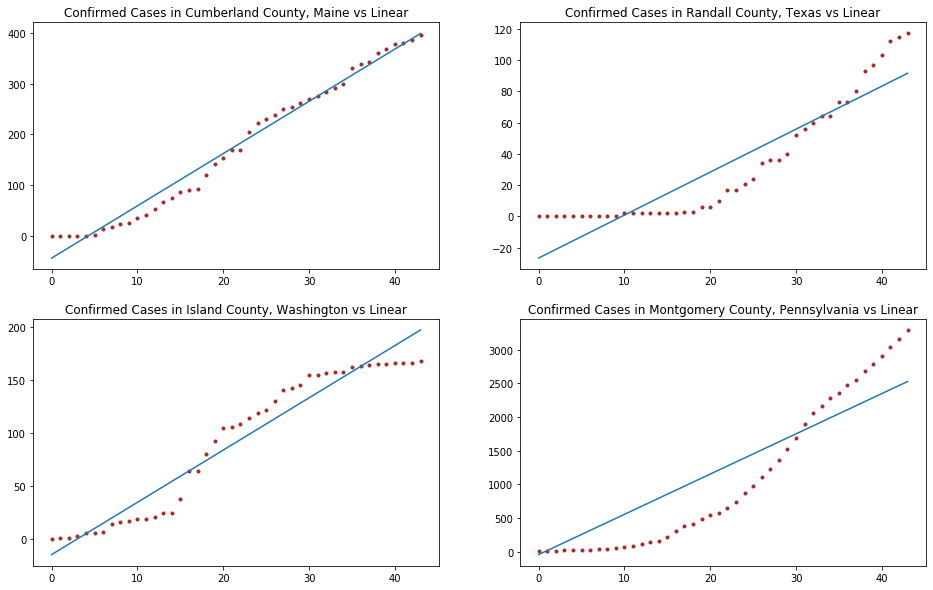

In [9]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

In [10]:
# Now let's fit some more appropriate curves to this data.
# First, break out the repetitive parts of the curve-fitting process into
# a Python function.
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,     
                 regularize_fn = None):
    """
    Fit a curve to a column full of time series.
    
    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.
    
    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.
    
    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].values.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = [
        scipy.optimize.minimize(
            objective, initial_guess,
            args=(ts), bounds=bounds)
        for ts in series_values
    ]
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [11]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate)(X - offset)
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """    
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))
    
    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curve sto each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)
    
    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        
        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))
        
        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)
    
    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])
    
    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )
    
    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


In [12]:
# Now we can fit those curves.
# First, the exponential curves.
exp_df = fit_exponential(ts_col_name)
exp_df

,State,County,Population,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 6315.280249103279, 'jac': [0.371710484...",0.118525,0.0,[ 1. 1.12583516 1.26750481 1.427...,0.917532
1017,Alabama,Chambers,33254,"{'fun': 106742.56995813662, 'jac': [0.50786184...",0.138364,0.0,[ 1. 1.14839323 1.31880701 1.514...,0.740007
1055,Alabama,Etowah,102268,"{'fun': 7315.382168070237, 'jac': [1.599983079...",0.115579,0.0,[ 1. 1.12252332 1.2600586 1.414...,0.886847
1073,Alabama,Jefferson,658573,"{'fun': 2289612.794445928, 'jac': [-24.9594449...",0.163128,0.0,[1.00000000e+00 1.17718717e+00 1.38576964e+00 1...,0.195596
1081,Alabama,Lee,164542,"{'fun': 194058.7490062361, 'jac': [-0.00582076...",0.143539,0.0,[ 1. 1.15435205 1.33252866 1.538...,0.662657
...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,"{'fun': 80708.55827749876, 'jac': [-0.33760443...",0.137814,0.0,[ 1. 1.1477626 1.31735898 1.512...,0.778062
55079,Wisconsin,Milwaukee,945726,"{'fun': 21761851.458507143, 'jac': [-16.763806...",0.189869,0.0,[1.00000000e+00 1.20909095e+00 1.46190092e+00 1...,0.209899
55101,Wisconsin,Racine,196311,"{'fun': 22508.387370653625, 'jac': [0.02182787...",0.128675,0.0,[ 1. 1.13732004 1.29349687 1.471...,0.872125


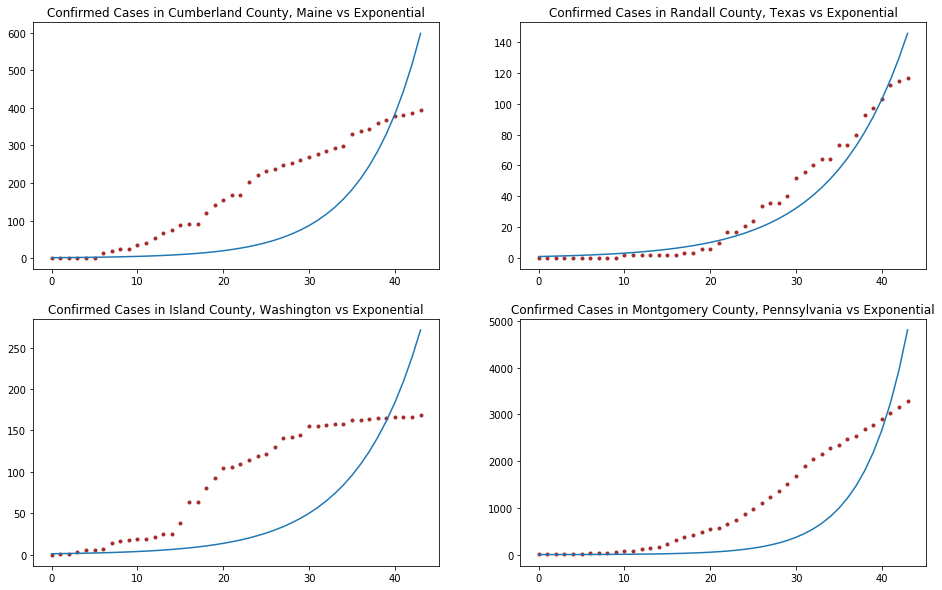

In [13]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

In [14]:
# Then fit the logistic function
log_df = fit_logistic(ts_col_name)
log_df

,State,County,Population,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 215.03597807035024, 'jac': [0.0, -0.00...",158.624305,0.164098,34.209097,[ 0.5765212 0.67889201 0.7993485 0.941...,0.997192
1017,Alabama,Chambers,33254,"{'fun': 1915.1213030781464, 'jac': [0.00018189...",275.485080,0.220758,29.380976,[ 0.41934416 0.52273446 0.65155551 0.812...,0.995335
1055,Alabama,Etowah,102268,"{'fun': 638.8145753225131, 'jac': [0.0, -2.273...",110.795489,0.227810,30.451233,[ 0.10748915 0.13495633 0.16943158 0.212...,0.990119
1073,Alabama,Jefferson,658573,"{'fun': 8780.837519130499, 'jac': [0.000727595...",730.578604,0.166973,24.547774,[ 11.92425496 14.0494824 16.54476325 19.471...,0.996915
1081,Alabama,Lee,164542,"{'fun': 3945.062912262057, 'jac': [9.094947017...",376.512465,0.162929,30.343741,[ 2.66434865 3.13189324 3.68067561 4.324...,0.993142
...,...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,"{'fun': 1287.8883087566853, 'jac': [-9.0949470...",306.657401,0.165476,31.520061,[ 1.6561537 1.95228913 2.30097682 2.711...,0.996458
55079,Wisconsin,Milwaukee,945726,"{'fun': 101250.42966884236, 'jac': [0.01309672...",2350.847142,0.162753,26.485827,[ 31.14166749 36.56023354 42.90417757 50...,0.996324
55101,Wisconsin,Racine,196311,"{'fun': 436.3851028235764, 'jac': [-3.41060513...",220.655272,0.176729,32.849688,[ 0.66239689 0.78998469 0.94204262 1.123...,0.997521


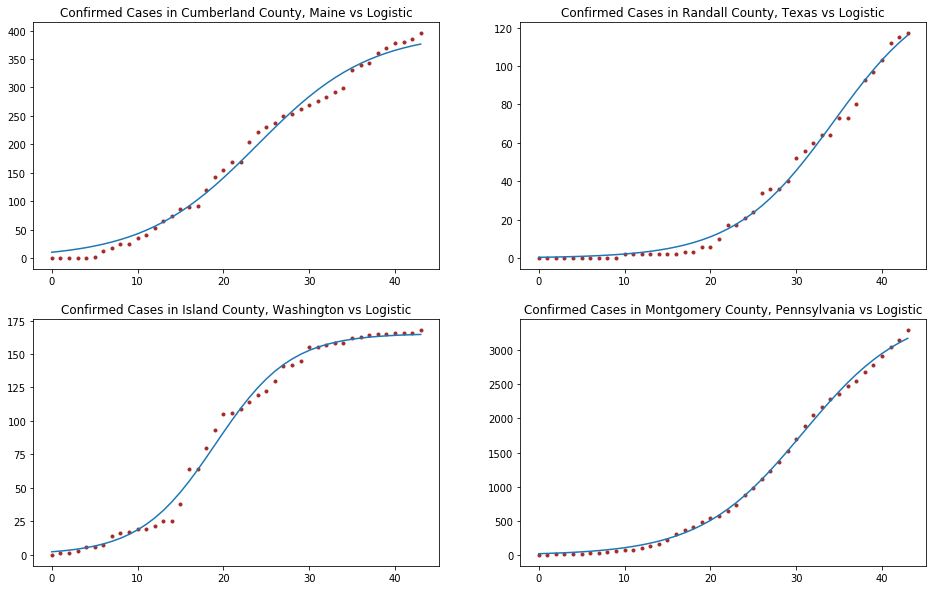

In [15]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

In [16]:
# And finally a mixture of two copies of the logistic function
log2_df = fit_logistic2(ts_col_name)
log2_df

,State,County,Population,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,"{'fun': 143.75351769387592, 'jac': [-2.5579538...",8404.191840,9.999365,34.893242,181.756496,0.137486,36.513680,8.265421,11.221145,[9.48177035e-03 1.51958265e-02 2.43190411e-02 3...,0.998123
1017,Alabama,Chambers,33254,"{'fun': 1109.1316414678956, 'jac': [-0.1398120...",495.821893,1.138239,31.802016,471.876147,0.073708,39.308081,16.631929,21.122666,[1.58746286e-01 2.12321298e-01 2.83783093e-01 3...,0.997298
1055,Alabama,Etowah,102268,"{'fun': 250.83312950749493, 'jac': [0.00096065...",161.061311,0.281990,30.567613,156.857203,0.309104,41.016133,30.445492,36.556687,[2.89936142e-02 3.84193102e-02 5.09042706e-02 6...,0.996120
1073,Alabama,Jefferson,658573,"{'fun': 2950.692657795306, 'jac': [0.311774783...",702.353046,0.237165,21.502973,747.921731,0.157646,25.039729,13.666943,14.666943,[ 4.25719244 5.38788881 6.81596241 8.617...,0.998963
1081,Alabama,Lee,164542,"{'fun': 1815.4908426959325, 'jac': [-0.0005911...",118.442597,9.999710,29.793212,490.536381,0.137205,29.516996,0.000063,44.000000,[ 3.91446512 4.53326183 5.24730124 6.070...,0.996844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,"{'fun': 302.2802886627107, 'jac': [0.006599520...",21.529504,7.735006,22.023750,456.650829,0.159909,23.540181,31.255906,44.000000,[ 0.52780278 0.66449206 0.83576115 1.050...,0.999169
55079,Wisconsin,Milwaukee,945726,"{'fun': 15505.076604134061, 'jac': [-3.3429387...",880.243696,0.274246,24.081244,3313.478233,0.434362,11.189058,33.380737,43.998760,[1.77184515e+00 2.55210748e+00 3.72677638e+00 5...,0.999437
55101,Wisconsin,Racine,196311,"{'fun': 219.88109670463743, 'jac': [0.02028741...",277.079468,10.000000,30.084307,277.535949,0.128437,36.493357,9.619115,14.815952,[1.19533558e-01 1.62918177e-01 2.21571999e-01 3...,0.998751


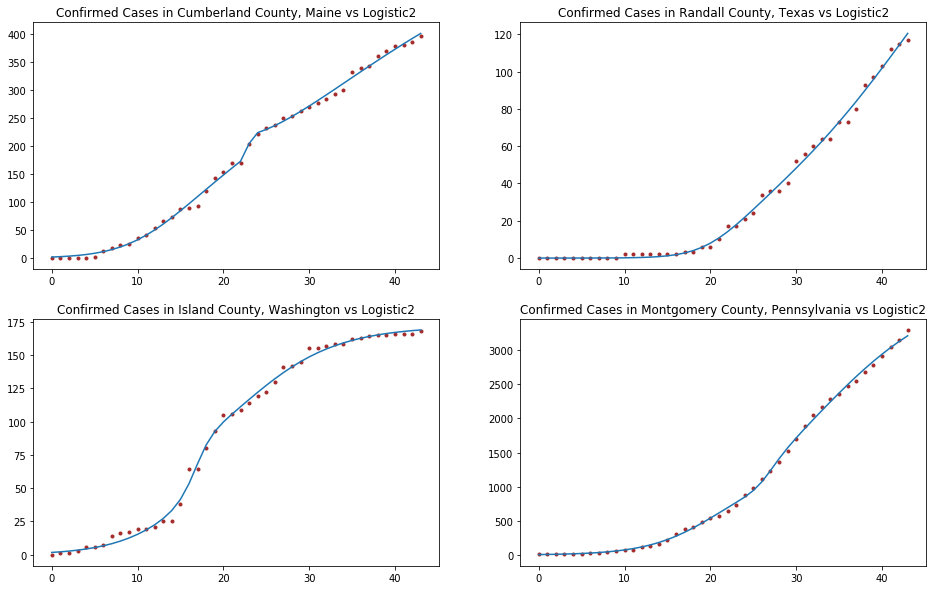

In [17]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

In [18]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12583516 1.26750481 1.427...,[ 0.5765212 0.67889201 0.7993485 0.941...,[9.48177035e-03 1.51958265e-02 2.43190411e-02 3...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14839323 1.31880701 1.514...,[ 0.41934416 0.52273446 0.65155551 0.812...,[1.58746286e-01 2.12321298e-01 2.83783093e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.12252332 1.2600586 1.414...,[ 0.10748915 0.13495633 0.16943158 0.212...,[2.89936142e-02 3.84193102e-02 5.09042706e-02 6...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.17718717e+00 1.38576964e+00 1...,[ 11.92425496 14.0494824 16.54476325 19.471...,[ 4.25719244 5.38788881 6.81596241 8.617...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.15435205 1.33252866 1.538...,[ 2.66434865 3.13189324 3.68067561 4.324...,[ 3.91446512 4.53326183 5.24730124 6.070...
...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,[ 0 0 0 0 0 0 1 4 4 4 4 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.1477626 1.31735898 1.512...,[ 1.6561537 1.95228913 2.30097682 2.711...,[ 0.52780278 0.66449206 0.83576115 1.050...
55079,Wisconsin,Milwaukee,945726,[ 0 0 0 2 6 6 13 24 47 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.20909095e+00 1.46190092e+00 1...,[ 31.14166749 36.56023354 42.90417757 50...,[1.77184515e+00 2.55210748e+00 3.72677638e+00 5...
55101,Wisconsin,Racine,196311,[ 0 0 0 1 1 1 1 1 1 3 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13732004 1.29349687 1.471...,[ 0.66239689 0.78998469 0.94204262 1.123...,[1.19533558e-01 1.62918177e-01 2.21571999e-01 3...


In [19]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-18  Wyoming  Laramie       99500         70              False   
      2020-04-19  Wyoming  Laramie       99500         71              False   
      2020-04-20  Wyoming  Laramie       99500         73              False   
      2020-04-21  Wyoming  Laramie       99500        110              False   
      2020-04-22  Wyoming  Laramie       99500        114              False   

                  Exponential   Logistic   Logistic2  
FIPS  Date                                            
1003  2020-03-10     1.000000   0.576521    0.009482  
      2020-03-11     1.125835   0.678892    0.015196  
      2020-03-12     1.267505   0.799348    0.024319  
      2020-03-13     1.427001   0.941050    0.038845  
      2020-03-14     1.606568   1.107696    0.061884  
...                       ...        ...         ...  
56021 2020-04-18    79.101762  80.500979   69.724340  
      2020-04-19    88.482543  83.790327   71.422990  
      2020-04-20    98.975804  86.965501   73.107654  
      2020-04-21   110.713474  90.013342  109.999442  
      2020-04-22   123.843129  92.923265  113.999673  

[25476 rows x 8 columns]

In [20]:
# Write out the results to a CSV file plus a JSON file of type metadata.
curves_vertical.to_csv("data/us_counties_curves.csv", index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}
with open("data/us_counties_curves_meta.json", "w") as f:
    json.dump(col_type_mapping, f)

In [21]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.118525,0.0,158.624305,0.164098,34.209097,8404.191840,9.999365,34.893242,181.756496,0.137486,36.513680,8.265421,11.221145
1017,Alabama,Chambers,33254,0.138364,0.0,275.485080,0.220758,29.380976,495.821893,1.138239,31.802016,471.876147,0.073708,39.308081,16.631929,21.122666
1055,Alabama,Etowah,102268,0.115579,0.0,110.795489,0.227810,30.451233,161.061311,0.281990,30.567613,156.857203,0.309104,41.016133,30.445492,36.556687
1073,Alabama,Jefferson,658573,0.163128,0.0,730.578604,0.166973,24.547774,702.353046,0.237165,21.502973,747.921731,0.157646,25.039729,13.666943,14.666943
1081,Alabama,Lee,164542,0.143539,0.0,376.512465,0.162929,30.343741,118.442597,9.999710,29.793212,490.536381,0.137205,29.516996,0.000063,44.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55059,Wisconsin,Kenosha,169561,0.137814,0.0,306.657401,0.165476,31.520061,21.529504,7.735006,22.023750,456.650829,0.159909,23.540181,31.255906,44.000000
55079,Wisconsin,Milwaukee,945726,0.189869,0.0,2350.847142,0.162753,26.485827,880.243696,0.274246,24.081244,3313.478233,0.434362,11.189058,33.380737,43.998760
55101,Wisconsin,Racine,196311,0.128675,0.0,220.655272,0.176729,32.849688,277.079468,10.000000,30.084307,277.535949,0.128437,36.493357,9.619115,14.815952


In [22]:
params.to_csv("data/us_counties_curves_params.csv", index=True)

In [23]:
!ls -lh data/us_counties_curves*

-rw-r--r--  1 freiss  staff   2.6M Apr 24 20:00 data/us_counties_curves.csv
-rw-r--r--  1 freiss  staff   186B Apr 24 20:00 data/us_counties_curves_meta.json
-rw-r--r--  1 freiss  staff   143K Apr 24 20:00 data/us_counties_curves_params.csv
